# Advanced Regression Technique

In [284]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
%matplotlib inline

## Import Dataset

In [348]:
# Import Dataset
test = pd.read_csv('/Users/wasin/Desktop/DA_Project/house-prices-advanced-regression-techniques/test.csv',index_col='Id')
train = pd.read_csv('/Users/wasin/Desktop/DA_Project/house-prices-advanced-regression-techniques/train.csv',index_col='Id')

In [349]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Divide numerical and categorical columns

In [350]:
# Divide numerical and categorical columns to analyse them seperately.

# numerical
num_cols = train.select_dtypes(include=['int','float64']).columns
# categorical
cat_cols = train.select_dtypes(include=['object']).columns
# Index to list
num_cols = num_cols.tolist()
cat_cols = cat_cols.tolist()
# Seperate num_cols and cat_cols dataframe
num_cols = train.loc[:, num_cols]
cat_cols = train.loc[:, cat_cols]

## Analyze num_cols

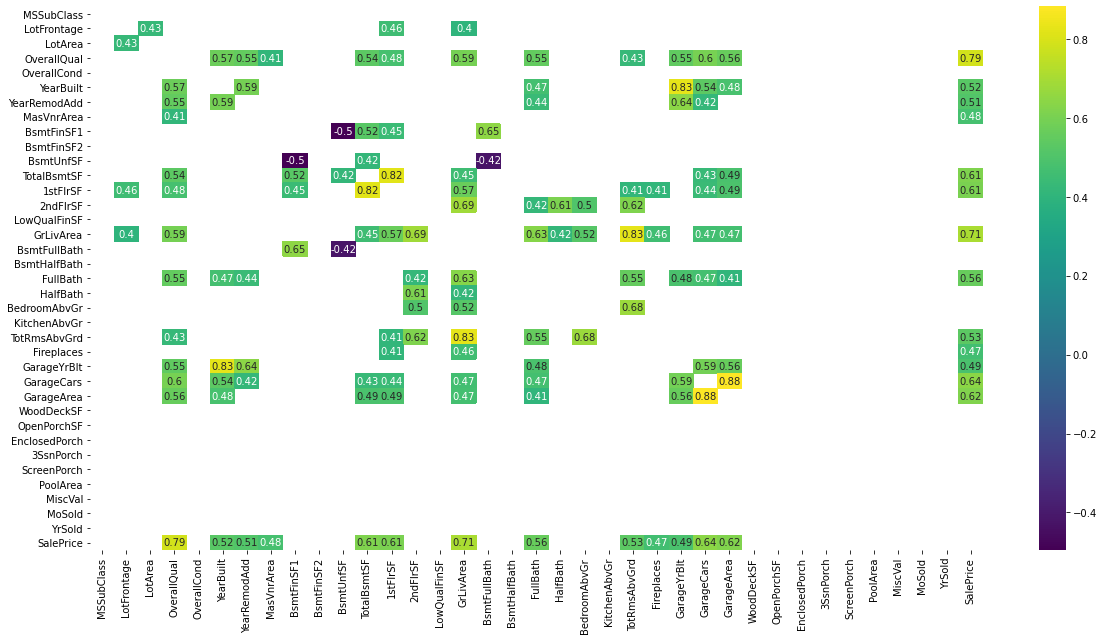

In [339]:
# Analyse numerical columns to identify the most relevent columns for the model.

# Plot heatmap to visualize correlation for num_cols
dfCorr = num_cols.corr()
filteredDf = dfCorr[((dfCorr >= .4) | (dfCorr <= -.4)) & (dfCorr !=1.000)]
plt.figure(figsize=(20,10))
sns.heatmap(filteredDf, annot=True, cmap="viridis",)
plt.show()

In [340]:
 # Creating a function to filter  and flattend correlation dataframe
def corrFilter(x: pd.DataFrame, bound: float):
    xCorr = x.corr()
    xFiltered = xCorr[((xCorr >= bound) | (xCorr <= -bound)) & (xCorr !=1.000)]
    xFlattened = xFiltered.unstack().sort_values().drop_duplicates()
    return xFlattened

# Set the correlation level at minimum of absolute 0.45
most_corr = corrFilter(num_cols, .4)

most_corr = most_corr.reset_index().rename(columns={'level_0': 'var1', 'level_1': 'var2', 0: 'Correlation'})
most_corr = most_corr.loc[ (most_corr['var1'] == 'SalePrice') | (most_corr['var2'] == 'SalePrice')].sort_values('Correlation',ascending=False)
most_corr

,var1,var2,Correlation
65,OverallQual,SalePrice,0.790982
64,GrLivArea,SalePrice,0.708624
59,GarageCars,SalePrice,0.640409
57,GarageArea,SalePrice,0.623431
55,TotalBsmtSF,SalePrice,0.613581
53,1stFlrSF,SalePrice,0.605852
44,SalePrice,FullBath,0.560664
37,SalePrice,TotRmsAbvGrd,0.533723
36,YearBuilt,SalePrice,0.522897
33,YearRemodAdd,SalePrice,0.507101


In [341]:
# Display a list of candidate  columns
candidates_num_cols = most_corr['var1'].astype(str).values.tolist() + most_corr['var2'].astype(str).values.tolist() 
candidates_num_cols_train = list(dict.fromkeys(candidates_num_cols)) 
candidates_num_cols_test  = list(dict.fromkeys(candidates_num_cols)) 
# Drop 'GarageCars' since similar to 'GarageArea'
candidates_num_cols_train.remove("GarageArea")
candidates_num_cols_test.remove("GarageArea")
# Remove Saleprice from test
candidates_num_cols_test.remove("SalePrice")

## Analyze cat_cols

In [342]:
# Analyse categorical columns to identify the most relevent columns for the model.

# Show repeating element.
remove1_cat_column = ['Street','LandContour','Condition2','BldgType',
                     'HouseStyle','RoofMatl','Exterior2nd','Electrical',
                     'BsmtFinType2','MiscFeature','PavedDrive','BsmtFinType1',
                     'GarageCond', ]

candidates_cat_cols = [element for element in cat_cols if element not in remove1_cat_column]
candidates_cat_cols

['MSZoning',
 'Alley',
 'LotShape',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'RoofStyle',
 'Exterior1st',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'PoolQC',
 'Fence',
 'SaleType',
 'SaleCondition']

In [344]:
new= train.loc[:,candidates_cat_cols]

In [347]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(transformers=[('cat', categorical_transformer, cat_cols)])
new =  np.array(preprocessor.fit_transform(new))

 

ValueError: No valid specification of the columns. Only a scalar, list or slice of all integers or all strings, or boolean mask is allowed

In [345]:
new

,MSZoning,Alley,LotShape,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,RoofStyle,Exterior1st,...,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,PoolQC,Fence,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,RL,NaN,Reg,AllPub,Inside,Gtl,CollgCr,Norm,Gable,VinylSd,...,Gd,Typ,NaN,Attchd,RFn,TA,NaN,NaN,WD,Normal
2,RL,NaN,Reg,AllPub,FR2,Gtl,Veenker,Feedr,Gable,MetalSd,...,TA,Typ,TA,Attchd,RFn,TA,NaN,NaN,WD,Normal
3,RL,NaN,IR1,AllPub,Inside,Gtl,CollgCr,Norm,Gable,VinylSd,...,Gd,Typ,TA,Attchd,RFn,TA,NaN,NaN,WD,Normal
4,RL,NaN,IR1,AllPub,Corner,Gtl,Crawfor,Norm,Gable,Wd Sdng,...,Gd,Typ,Gd,Detchd,Unf,TA,NaN,NaN,WD,Abnorml
5,RL,NaN,IR1,AllPub,FR2,Gtl,NoRidge,Norm,Gable,VinylSd,...,Gd,Typ,TA,Attchd,RFn,TA,NaN,NaN,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,RL,NaN,Reg,AllPub,Inside,Gtl,Gilbert,Norm,Gable,VinylSd,...,TA,Typ,TA,Attchd,RFn,TA,NaN,NaN,WD,Normal
1457,RL,NaN,Reg,AllPub,Inside,Gtl,NWAmes,Norm,Gable,Plywood,...,TA,Min1,TA,Attchd,Unf,TA,NaN,MnPrv,WD,Normal
1458,RL,NaN,Reg,AllPub,Inside,Gtl,Crawfor,Norm,Gable,CemntBd,...,Gd,Typ,Gd,Attchd,RFn,TA,NaN,GdPrv,WD,Normal


## Filter Columns

In [315]:
train_columns = candidates_num_cols_train + candidates_cat_cols
train = train.loc[:, train_columns]
test_columns = candidates_num_cols_test  + candidates_cat_cols
test = test.loc[:, test_columns]

In [293]:
test.head()

,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,1stFlrSF,YearBuilt,YearRemodAdd,GarageYrBlt,Fireplaces,FullBath,...,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,PoolQC,Fence,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,5,896,1.0,882.0,896,1961,1961,1961.0,0,1,...,TA,Typ,NaN,Attchd,Unf,TA,NaN,MnPrv,WD,Normal
1462,6,1329,1.0,1329.0,1329,1958,1958,1958.0,0,1,...,Gd,Typ,NaN,Attchd,Unf,TA,NaN,NaN,WD,Normal
1463,5,1629,2.0,928.0,928,1997,1998,1997.0,1,2,...,TA,Typ,TA,Attchd,Fin,TA,NaN,MnPrv,WD,Normal
1464,6,1604,2.0,926.0,926,1998,1998,1998.0,1,2,...,Gd,Typ,Gd,Attchd,Fin,TA,NaN,NaN,WD,Normal
1465,8,1280,2.0,1280.0,1280,1992,1992,1992.0,0,2,...,Gd,Typ,NaN,Attchd,RFn,TA,NaN,NaN,WD,Normal


In [294]:
train.head()

,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,1stFlrSF,SalePrice,YearBuilt,YearRemodAdd,GarageYrBlt,Fireplaces,...,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,PoolQC,Fence,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,7,1710,2,856,856,208500,2003,2003,2003.0,0,...,Gd,Typ,NaN,Attchd,RFn,TA,NaN,NaN,WD,Normal
2,6,1262,2,1262,1262,181500,1976,1976,1976.0,1,...,TA,Typ,TA,Attchd,RFn,TA,NaN,NaN,WD,Normal
3,7,1786,2,920,920,223500,2001,2002,2001.0,1,...,Gd,Typ,TA,Attchd,RFn,TA,NaN,NaN,WD,Normal
4,7,1717,3,756,961,140000,1915,1970,1998.0,1,...,Gd,Typ,Gd,Detchd,Unf,TA,NaN,NaN,WD,Abnorml
5,8,2198,3,1145,1145,250000,2000,2000,2000.0,1,...,Gd,Typ,TA,Attchd,RFn,TA,NaN,NaN,WD,Normal


In [316]:
# Checking out dataset
print('Dataset size: ' ,len(train))
print('Datatype:')

print(train.dtypes)

Dataset size:  1460
Datatype:
OverallQual        int64
GrLivArea          int64
GarageCars         int64
TotalBsmtSF        int64
1stFlrSF           int64
SalePrice          int64
YearBuilt          int64
YearRemodAdd       int64
GarageYrBlt      float64
Fireplaces         int64
FullBath           int64
TotRmsAbvGrd       int64
MasVnrArea       float64
MSZoning          object
Alley             object
LotShape          object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
RoofStyle         object
Exterior1st       object
MasVnrType        object
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
Heating           object
HeatingQC         object
CentralAir        object
KitchenQual       object
Functional        object
FireplaceQu       object
GarageType        object
GarageFinish      object
GarageQual        ob

In [317]:
# DependentVariable
y_train = train.loc[:,'SalePrice']
y_train

Id
1       208500
2       181500
3       223500
4       140000
5       250000
         ...  
1456    175000
1457    210000
1458    266500
1459    142125
1460    147500
Name: SalePrice, Length: 1460, dtype: int64

In [318]:
# IndependentVariable
train.drop(['SalePrice'], axis=1,inplace=True)
train

,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,1stFlrSF,YearBuilt,YearRemodAdd,GarageYrBlt,Fireplaces,FullBath,...,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,PoolQC,Fence,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,7,1710,2,856,856,2003,2003,2003.0,0,2,...,Gd,Typ,NaN,Attchd,RFn,TA,NaN,NaN,WD,Normal
2,6,1262,2,1262,1262,1976,1976,1976.0,1,2,...,TA,Typ,TA,Attchd,RFn,TA,NaN,NaN,WD,Normal
3,7,1786,2,920,920,2001,2002,2001.0,1,2,...,Gd,Typ,TA,Attchd,RFn,TA,NaN,NaN,WD,Normal
4,7,1717,3,756,961,1915,1970,1998.0,1,1,...,Gd,Typ,Gd,Detchd,Unf,TA,NaN,NaN,WD,Abnorml
5,8,2198,3,1145,1145,2000,2000,2000.0,1,2,...,Gd,Typ,TA,Attchd,RFn,TA,NaN,NaN,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,6,1647,2,953,953,1999,2000,1999.0,1,2,...,TA,Typ,TA,Attchd,RFn,TA,NaN,NaN,WD,Normal
1457,6,2073,2,1542,2073,1978,1988,1978.0,2,2,...,TA,Min1,TA,Attchd,Unf,TA,NaN,MnPrv,WD,Normal
1458,7,2340,1,1152,1188,1941,2006,1941.0,2,2,...,Gd,Typ,Gd,Attchd,RFn,TA,NaN,GdPrv,WD,Normal


## Splitting train dataset

In [319]:
# Splitting the train dataset 
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(train, y_train,train_size=0.8, test_size=0.2,random_state=0)

## Pipiline

<1x183 sparse matrix of type '<class 'numpy.float64'>'
	with 42 stored elements in Compressed Sparse Row format>

In [174]:
# Training the Multiple Linear Regression model on the Training set

from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [176]:
# Predicting the Test set results

y_pred = regressor.predict(X_valid)

Text(0, 0.5, 'Predicted Y')

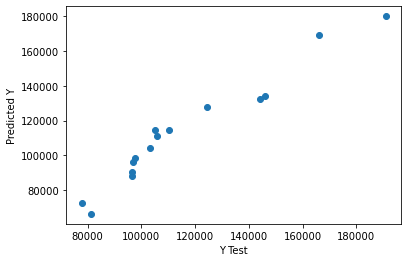

In [177]:
#Create a scatterplot of the real test values versus the predicted values

plt.scatter(y_valid,y_pred)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

In [178]:
# calculate these metrics by hand!
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_valid, y_pred))
print('MSE:', metrics.mean_squared_error(y_valid, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid, y_pred)))

MAE: 6520.697183079721
MSE: 61903144.40236705
RMSE: 7867.855133539702


/Users/wasin/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


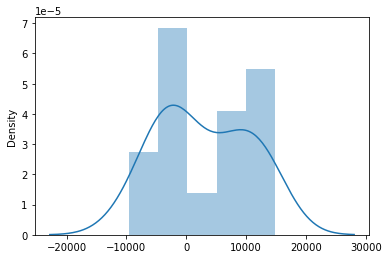

In [184]:
sns.distplot((y_valid-y_pred),bins=5);